# Auswertung von Tweets nach der Wahlnacht

Im Folgenden werden Tweets, die am Tag und in der Nacht nach der Wahlnacht 2020 in den USA versendet wurden, analysiert. Es wurden nicht alle Tweets festgehalten.<br><br>
Die Tweets wurden nach den Keywords: Trump, Biden und Election gefiltert.

## Imports

`pip3 install -r requirements.txt`

In [1]:
from pymongo import MongoClient
from bson.json_util import loads, dumps
import json
import nltk
from nltk.corpus import stopwords
import collections
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Math, Latex

## Füllwörter

In [2]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/felixwortmann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Datenbankverbindung herstellen
Es wurde ein Docker-Container für die MongoDB gestartet mit Port 27017. Die Daten werden mit Python-Skripts in die Datenbank geladen, indem zuerst ein Skript die Daten von der API anfragt und mittels Apache Kafka zwischenspeichert. Von dort aus werden die Daten nacheinander in die Datenbank eingefügt sodass letztlich in diesem Notebook darauf zugegriffen werden kann.

In [3]:
client = MongoClient('mongodb://ubuntu-server:27017')
db = client['twitter']
collection = db['tweets']

## Daten laden

Daten direkt aus Datenbank laden

In [ ]:
%%time
data = json.loads(dumps(collection.find()))

In [ ]:
len(data)

Daten aus Test-Datei mit 50.000 Einträgen laden

In [4]:
%%time
with open("50000.json", "r", encoding="utf-8") as f:
    data = json.loads(f.read())

CPU times: user 6.09 s, sys: 1.64 s, total: 7.73 s
Wall time: 7.75 s


## Rausfiltern der Tweet-Inhalte
{
    ('word', 'year'): #count
}

In [5]:
text_strings = []
for d in data:
    if "text" in d.keys():
        text_strings += [d["text"]]

words_dict = {}
for d in data:
    if not "text" in d.keys() or not "user" in d.keys() or not "created_at" in d["user"].keys() or d["user"]["created_at"] == None:
        continue
    text = d["text"].lower()
    created = d["user"]["created_at"][-4:]
    
    for word in text.split(' '):
        pair = (word, created)
        if pair in words_dict.keys():
            words_dict[pair] += 1
        else:
            words_dict[pair] = 1

## Wort-Jahr-Anzahl

In [6]:
ignore_words = stop_words + ['rt', '', '-', '&amp;', 'like', 'get', 'one', 'via', 'new', 'i\'m', 'rt']
words = [(k,v) for k, v in sorted(words_dict.items(), key=lambda item: -item[1]) if k[0] not in ignore_words]
words[:10]

[(('trump', '2020'), 2225),
 (('biden', '2020'), 1501),
 (('trump', '2009'), 1436),
 (('trump', '2011'), 1234),
 (('trump', '2019'), 1156),
 (('trump', '2012'), 1128),
 (('trump', '2017'), 1083),
 (('trump', '2018'), 1061),
 (('trump', '2013'), 1042),
 (('trump', '2016'), 986)]

## Top-5 Wörter pro Jahr der Account-Erstellung

In [13]:
result = {}

for pair in words_dict.keys():
    word, year = pair
    amount = (word, words_dict[pair])
    
    if year in result.keys():              
        result[year] = result[year] + [(word, words_dict[pair])]
            
    else:
        result[year] = [(word, words_dict[pair])]

for year in sorted(result.keys()):
    print(year)
    value = result[year]
    r = [(k,v) for k, v in sorted(value, key=lambda item: -item[1]) if k not in ignore_words]
    for x in r[:5]:
        pass
        #print("    ", x[0],":", x[1])

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


## Durchschnittliches Alter der Accounts

In [8]:
years = [int(year) for d in data if "user" in d.keys() for year in [d["user"]["created_at"][-4:]]]
sum(years) / len(years)

2014.5543768742732

## Plotting von Daten

Beispiel: Jahr der Account-Erstellung vs. Verwendung eines Wortes

Hilfsmethoden

In [9]:
def words_by_account_year(word_set):
    word_result = {}
    for y in result.keys():
        for w,c in result[y]:
            if w in word_set:
                if y in word_result.keys():
                    word_result[y] += c
                else:
                    word_result[y] = c
    return [(y, word_result[y]) for y in sorted(word_result)]

def plot_by_account_year(word_set):
    wl = words_by_account_year(word_set)
    group_names = list([k for k,v in wl])
    group_data = list([v for k,v in wl])
    return group_names,group_data

<div style="page-break-after: always;"></div>

### Untersuchung von Wörtern: 
{
"fraud",
"lie",
"steal",
"cheating",
"swindling",
"desception",
"trickery",
"illegal"
}

<BarContainer object of 14 artists>

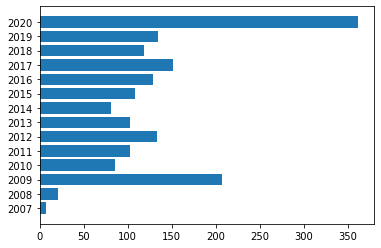

In [10]:
fig, ax = plt.subplots()
key_data, value_data = plot_by_account_year({"fraud","lie","steal","cheating","swindling","desception","trickery","illegal"})
ax.barh(key_data,value_data)

### Folgerung

Die Daten lassen vermuten, dass viele Accounts zur Zeit der Wahl erstellt wurden, um sich dazu zu äußern.
<br><br>
Im Jahr 2008 hat Barack Obama als Demokrat die Wahl gewonnen, woraufhin er 2009 Präsident wurde. Joe Biden war hier Vizepräsident<br> 
2020 hat Donald Trump die Wahl als Republikaner verloren. <br><br>

Es ist zu vermuten, dass die Accounts, die damals erstellt wurden, einen Standpunkt vertreten, wie die Accounts von 2020. Die Wörter, nach denen wir gesucht haben, lassen auch vermuten, dass die Accountinhaber die Wahlergebnisse nicht akzepieren.
<br><br>
Aufgrund der verhältnismäßig kleinen Datenmenge von nur 50.000 Tweets über einen kurzen Zeitraum, sind dies allerdings nur Vermutungen.

<div style="page-break-after: always;"></div>

### Untersuchung von Wörtern: 
{
"congratulations",
"united",
"party",
"win",
"president-elect",
"elect"
}

<BarContainer object of 14 artists>

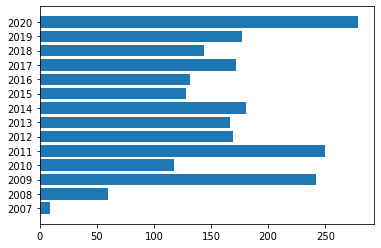

In [11]:
fig, ax = plt.subplots()
key_data, value_data = plot_by_account_year({
"congratulations",
"united",
"party",
"win",
"president-elect",
"elect"
})
ax.barh(key_data,value_data)

### Folgerung

Diese Ergebnisse untermauern die obige Vermutung, weil zwar die Suche bei allen Tweets nach "Trump","Biden" und "Election" war, jedoch sind die Erstellungsdaten der Accounts relativ verteilt. Beispielsweise würden die zweitmeisten Accounts 2011 erstellt, wo keine Präsidentschaftswahl war.<br><br> Es liegt daher nicht nahe, dass die Accounts nur erstellt wurden, um über die Wahl zu Twittern.

## Analyse von Hashtags

In [31]:
hashtag_dir = {}
for tweet in data:
    # print(json.dumps(tweet,indent=4, sort_keys=True))
    if "entities" in tweet.keys():
        hashtags = tweet["entities"]["hashtags"]
        for hashtag in hashtags:
            hashtag_text = hashtag["text"].lower()
            if hashtag_text not in hashtag_dir.keys():
                hashtag_dir[hashtag_text] = 0
            hashtag_dir[hashtag_text] += 1
hashtag_dir = [(k,v) for k, v in sorted(hashtag_dir.items(), key=lambda item: -item[1]) if k not in ignore_words]
hashtag_dir

[('election2020', 448),
 ('biden', 334),
 ('trump', 317),
 ('elections2020', 285),
 ('michigan', 154),
 ('wisconsin', 130),
 ('counteveryvote', 93),
 ('apracecall', 80),
 ('breaking', 75),
 ('biden2020', 73),
 ('trump2020', 65),
 ('elecciones2020', 58),
 ('electionday', 56),
 ('crowderdebatestream', 54),
 ('uselection2020', 53),
 ('cnnelection', 50),
 ('electionnight', 49),
 ('uselection', 40),
 ('arizona', 37),
 ('gotrumpreeleito', 37),
 ('últimahora', 32),
 ('maga', 32),
 ('usaelections2020', 31),
 ('stopthesteal', 31),
 ('voterfraud', 28),
 ('bidenharris2020', 28),
 ('trumpvsbiden', 27),
 ('eyesonmi', 26),
 ('elecciones', 26),
 ('joebiden', 25),
 ('philadelphia', 23),
 ('detroit', 20),
 ('nevada', 19),
 ('eleccioneseeuu', 19),
 ('countallthevotes', 18),
 ('4nov', 17),
 ('everyvotecounts', 16),
 ('pennsylvania', 15),
 ('az', 15),
 ('fightback', 15),
 ('usa', 15),
 ('ahora', 15),
 ('election', 15),
 ('wisconsinwithlove', 15),
 ('withlove', 15),
 ('eeuu', 15),
 ('eleicoesamericanas2020